encoding: utf-8  

dataset information:  
Title: Zoo database (https://archive.ics.uci.edu/ml/datasets/zoo)  
Number of Instances: 101  
Number of Attributes: 18 (animal name, 15 Boolean attributes, 2 numerics)  
Attribute Information: (name of attribute and type of value domain)
1. animal name:      Unique for each instance
2. hair		Boolean
3. feathers		Boolean
4. eggs		Boolean
5. milk		Boolean
6. airborne		Boolean
7. aquatic		Boolean
8. predator		Boolean
9. toothed		Boolean
10. backbone		Boolean
11. breathes		Boolean
12. venomous		Boolean
13. fins		Boolean
14. legs		Numeric (set of values: {0,2,4,5,6,8})
15. tail		Boolean
16. domestic		Boolean
17. catsize		Boolean
18. type		Numeric (integer values in range [1,7])

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Part 0: Preprocessing

In [21]:
# I/O
with open('./dataset/zoo.data') as f:
    contents = []
    for line in f.readlines():
        contents.append(line.strip().split())

In [22]:
dataset = []
for i in range(len(contents)):
    str = contents[i][0]
    result = [x for x in str.split(',')]
    for k in range(1,len(result)):
        result[k] = int(result[k]) # convert attribution from string to int
    dataset.append(result)

In [23]:
print(f'The dataset has {len(dataset)} data points and {len(dataset[0])} attributes.')

The dataset has 101 data points and 18 attributes.


In [24]:
# obtain data_matrix only with 16 useful attributes
# by removing variable 1. animal name and classification result 18. type
# store 18.type independently in a list
data_matrix = []
data_type = []
for data_point in dataset:
    data_matrix.append(data_point[1:len(data_point)-1])
    data_type.append(data_point[-1])
data_matrix = np.asarray(data_matrix, dtype=np.float32)
#print(data_matrix)

### Part I: PCA

In [25]:
def my_pca(data=data_matrix, k=2):
    """
    Dimension reduction process using PCA.
    
    Input:
        data, data matrix with data points in rows and attributes in columns.
        k, number of dimensions we expected.
    Output:
        low_dim_data: data matrix after dimension reduction.
    """
    
    # data centering
    mean_vals = np.mean(data, axis=0)
    mean_removed = data - mean_vals
    #print(mean_removed)
    
    # compute covariance matrix
    cov_matrix = np.cov(mean_removed, rowvar=False) # rowvar=False means each col represents a variable, each row represents an observation
    #print(cov_matrix)
    
    # apply SVD on covariance matrix
    # obtain singular values and singular vectors
    e_values, e_vectors = np.linalg.eig(cov_matrix)
    # sort by singular values 
    e_values_sort = np.argsort(e_values)
    # filter the largest 2 singular values and their corresponding singular vectors
    # since we want to project the data in 2D
    #e_values_filter = e_values[0:k]
    #e_vectors_filter = e_vectors[:,0:k]
    e_values_sort = e_values_sort[:-(k+1):-1]
    e_vectors_filter = e_vectors[:,e_values_sort] # the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    #print(e_vectors_filter)
    
    # project the high dimentional data into low dimensional 2D space
    low_dim_data = np.dot(mean_removed, e_vectors_filter)
    print(f'The dimension of dataset after applying PCA is {len(low_dim_data)}x{len(low_dim_data[0])}.')
    # reconstruct original high dimensional data
    re_data_matrix = np.dot(low_dim_data, np.transpose(e_vectors_filter)) + mean_vals
    
    return low_dim_data

#### Result

In [26]:
pca_result = my_pca()

# link 2 selected attributes of each data point 
# with 'type' attribute in original dataset
pca_df = pd.DataFrame(dict(pca_attr1=pca_result[:,0], pca_attr2=pca_result[:,1], data_type=data_type))

The dimension of dataset after applying PCA is 101x2.


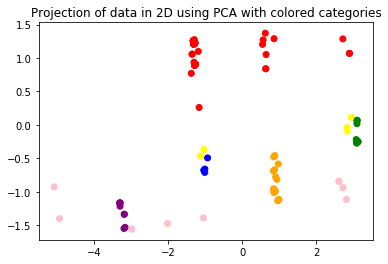

In [27]:
fig, ax = plt.subplots()
colors = {1:'red', 2:'orange', 3:'yellow', 4:'green', 5:'blue', 6:'purple', 7:'pink'}
ax.scatter(pca_df['pca_attr1'], pca_df['pca_attr2'], 
           c=pca_df['data_type'].apply(lambda x: colors[x]))
plt.title('Projection of data in 2D using PCA with colored categories')
plt.show()

### Part II: MDS

In [28]:
def distance_func(data=data_matrix):
    """
    Compute pairwise distance between any two data points.
    (a-b)^2 = a^2 + b^2 - 2*a*b.
    
    Input:
        data, data_matrix, a.k.a. a position matrix.
    Output:
        distance_matrix.
    """
    
    sum_data = np.sum(np.square(data),1)
    distance_matrix = np.add(np.transpose(np.add(-2 * np.dot(data, np.transpose(data)), sum_data)), sum_data)
    
    return distance_matrix

In [29]:
def my_mds(data=data_matrix, k=2):
    """
    Dimension reduction process using classical MDS.
    
    Input:
        data, data matrix with data points in rows and attributes in columns.
        k, number of dimensions we expected.
    Output:
        low_dim_data: data matrix after dimension reduction.
    """
    
    n, d = data.shape
    
    # compute distance matrix
    distance_matrix = distance_func()
    distance_matrix[distance_matrix < 0] = 0 # ensure distance_matrix is semidefinite

    # estimate S by double centering trick
    T1 = np.ones((n,n)) * np.sum(distance_matrix) / n**2
    T2 = np.sum(distance_matrix, axis=1, keepdims=True) / n
    T3 = np.sum(distance_matrix, axis=0, keepdims=True) / n
    S = -(T1-T2-T3+distance_matrix) / 2
    
    # compute eigen-decomposition
    e_values, e_vectors = np.linalg.eig(S)
    
    # sort and select the most important k dimensions
    index = np.argsort(-e_values)[0:2]
    e_values_select = e_values[index].real
    e_vectors_select = e_vectors[:, index]
    
    # a k-dimensional representation of the data
    low_dim_data = e_vectors_select * e_values_select ** (0.5)
    
    return low_dim_data

#### Result

In [30]:
mds_result = my_mds()
print(f'The dimension of dataset after applying MDS is {len(mds_result)}x{len(mds_result[0])}.')

# link 2 selected attributes of each data point 
# with 'type' attribute in original dataset
mds_df = pd.DataFrame(dict(mds_attr1=mds_result[:,0], mds_attr2=mds_result[:,1], data_type=data_type))

The dimension of dataset after applying MDS is 101x2.


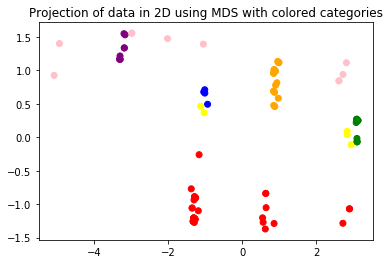

In [31]:
fig, ax = plt.subplots()
colors = {1:'red', 2:'orange', 3:'yellow', 4:'green', 5:'blue', 6:'purple', 7:'pink'}
ax.scatter(mds_df['mds_attr1'], mds_df['mds_attr2'], 
           c=mds_df['data_type'].apply(lambda x: colors[x]))
plt.title('Projection of data in 2D using MDS with colored categories')
plt.show()

### Part III: Isomap

In [67]:
def floyd(D, n_neighbors=15):
    """
    Construct a graph G, where vertices represent points,
    and each point is connected to its n_neighbors nearest points, 
    according to Euclidean distances.
    
    For each pair of points i and j compute the shortest path distance
    from i to j on the graph G using the Floyd-Warshall algorithm.
    
    Input:
        D, distance matrix.
        n_neighbors: neighborhood area to search shortest distance.
    Output:
        D1, shortest distance matrix.
    """
    
    Max = np.max(D)*1000
    n1, n2 = D.shape
    k = n_neighbors
    D1 = np.ones((n1,n1)) * Max
    D_arg = np.argsort(D, axis=1)
    for i in range(n1):
        D1[i, D_arg[i,0:k+1]] = D[i, D_arg[i,0:k+1]]
    for k in range(n1):
        for i in range(n1):
            for j in range(n1):
                if D1[i,k] + D1[k,j] < D1[i,j]:
                    D1[i,j] = D1[i,k] + D1[k,j]
                    
    return D1

In [68]:
def isomap_mds(distance_matrix, k=2):
    """
    MDS function using in Isomap process exclusively.
    
    Input:
        data, data matrix with data points in rows and attributes in columns.
        k, number of dimensions we expected.
    Output:
        low_dim_data: data matrix after dimension reduction.
    """
    
    distance_matrix = distance_matrix**2
    n = distance_matrix.shape[0]
    
    # estimate S by double centering trick
    T1 = np.ones((n,n)) * np.sum(distance_matrix) / n**2
    T2 = np.sum(distance_matrix, axis=1, keepdims=True) / n
    T3 = np.sum(distance_matrix, axis=0, keepdims=True) / n
    S = -(T1-T2-T3+distance_matrix) / 2
    
    # compute eigen-decomposition
    e_values, e_vectors = np.linalg.eig(S)
    
    # sort and select the most important k dimensions
    index = np.argsort(-e_values)[0:2]
    e_values_select = e_values[index].real
    e_vectors_select = e_vectors[:, index]
    
    # a k-dimensional representation of the data
    low_dim_data = e_vectors_select * e_values_select ** (0.5)
    
    return low_dim_data

In [73]:
def my_isomap(n_neighbors, data=data_matrix, k=2):
    """
    Dimension reduction process using Isomap.
    
    Input:
        data, data matrix with data points in rows and attributes in columns.
        k, number of dimensions we expected.
    Output:
        low_dim_data: data matrix after dimension reduction.
    """
    
    # compute Euclidean distances in the original space
    D = distance_func()
    D[D < 0] = 0
    D = D**0.5
    
    # Construct a graph
    # apply Floyd-Warshall algorithm to find shortest distances.
    D_floyd = floyd(D, n_neighbors)
    
    # use MDS on the shortest-path distances
    low_dim_data = isomap_mds(distance_matrix=D_floyd)
    
    return low_dim_data

#### Result

In [94]:
def plot_with_param(n_neighbors):

    isomap_result = my_isomap(n_neighbors)
    print(f'The dimension of dataset after applying Isomap is {len(isomap_result)}x{len(isomap_result[0])}.')

    # link 2 selected attributes of each data point 
    # with 'type' attribute in original dataset
    isomap_df = pd.DataFrame(dict(isomap_attr1=isomap_result[:,0], isomap_attr2=isomap_result[:,1], data_type=data_type))
    
    fig, ax = plt.subplots()
    colors = {1:'red', 2:'orange', 3:'yellow', 4:'green', 5:'blue', 6:'purple', 7:'pink'}
    ax.scatter(isomap_df['isomap_attr1'], isomap_df['isomap_attr2'], 
               c=isomap_df['data_type'].apply(lambda x: colors[x]))
    plt.title(f'Projection of data in 2D using Isomap with n_neighbors={n_neighbors}')

The dimension of dataset after applying Isomap is 101x2.
The dimension of dataset after applying Isomap is 101x2.
The dimension of dataset after applying Isomap is 101x2.
The dimension of dataset after applying Isomap is 101x2.
The dimension of dataset after applying Isomap is 101x2.
The dimension of dataset after applying Isomap is 101x2.
The dimension of dataset after applying Isomap is 101x2.


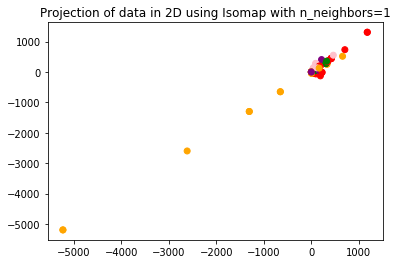

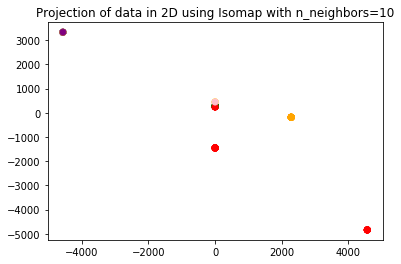

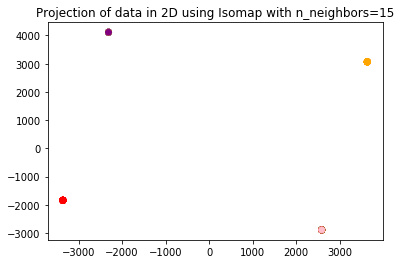

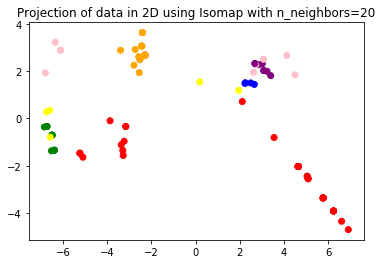

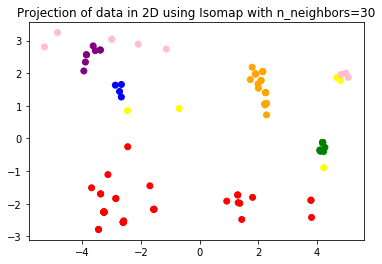

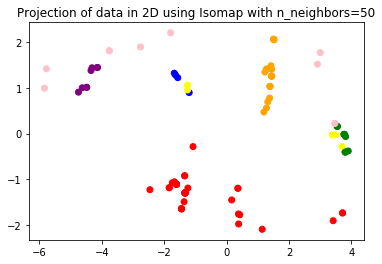

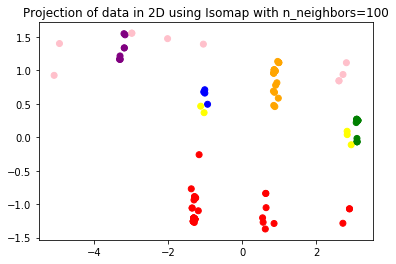

In [104]:
for n_neighbors in [1,10,15,20,30,50,100]:
    plot_with_param(n_neighbors)
plt.show()